In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
import pandas_datareader as web

In [ ]:
start = dt.datetime(2011,1,17)
end = dt.datetime(2020,12,31)
ds = web.DataReader("TCS.NS","yahoo",start,end)

In [ ]:
ds.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-28,2949.699951,2902.0,2910.000000,2929.399902,2108994.0,2923.835938
2020-12-29,2952.000000,2920.0,2920.000000,2930.500000,1994151.0,2924.933838
2020-12-30,2947.699951,2902.0,2934.399902,2909.300049,2637968.0,2903.774170
2020-12-31,2905.000000,2845.0,2900.000000,2862.750000,4040956.0,2857.312500
2021-01-01,2940.000000,2879.0,2880.000000,2928.250000,2681440.0,2922.688232


In [ ]:
# setting index as date
# ds['Date'] = pd.to_datetime(ds.Date,format='%Y-%m-%d')
# ds.index = ds['Date']

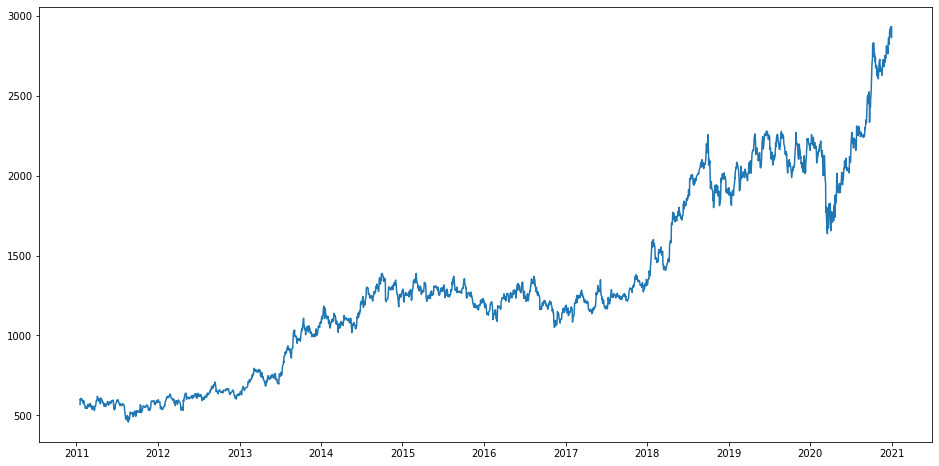

In [ ]:
# plot
plt.figure(figsize=(16,8))
plt.plot(ds['Close'], label='Close Price history')

In [ ]:
sc = MinMaxScaler()
train_set=sc.fit_transform(ds['Close'][:2459].values.reshape(-1,1))

### Long short term Memory

In [ ]:
past_days = 30

In [ ]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
# define input sequence
timeseries_data = ds['Close'][:6100].tolist()
# choose a number of time steps
n_steps = past_days
# split into samples
X, y = prepare_data(timeseries_data, n_steps)

In [ ]:
X.shape

(2422, 30)

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
# define model
callback = [EarlyStopping(monitor='loss', mode='auto',)]
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',)
# fit model
model.fit(X, y, epochs=30, verbose=1)

Epoch 1/30
76/76 [==============================] - 4s 32ms/step - loss: 9827713.9740
Epoch 2/30
76/76 [==============================] - 2s 32ms/step - loss: 33244.0936
Epoch 3/30
76/76 [==============================] - 2s 32ms/step - loss: 21815.0491
Epoch 4/30
76/76 [==============================] - 2s 32ms/step - loss: 92243.3555
Epoch 5/30
76/76 [==============================] - 2s 32ms/step - loss: 66233.3382
Epoch 6/30
76/76 [==============================] - 2s 31ms/step - loss: 103273.4399
Epoch 7/30
76/76 [==============================] - 2s 31ms/step - loss: 11010.3471
Epoch 8/30
76/76 [==============================] - 2s 31ms/step - loss: 11016.2356
Epoch 9/30
76/76 [==============================] - 2s 31ms/step - loss: 4495.0760
Epoch 10/30
76/76 [==============================] - 2s 32ms/step - loss: 5947.8652
Epoch 11/30
76/76 [==============================] - 2s 31ms/step - loss: 6224.0666
Epoch 12/30
76/76 [==============================] - 2s 31ms/step - loss: 

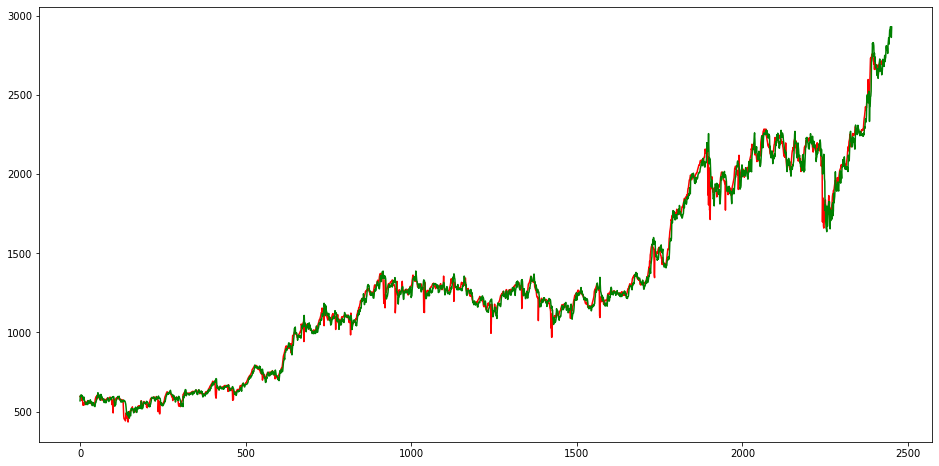

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(model.predict(X),color='red',label='Predicted')
plt.plot(ds['Close'].values,color='green',label='Actual')

In [ ]:
model_json = model.to_json()
with open("lstmModel_final.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("weights_final.h5")

In [ ]:
        from tensorflow.keras.models import model_from_json
        path = 'lstmModel_final.json'
        weights = 'weights_final.h5'
        # print(weights)
        # print(path)
        json_file = open(path, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        model.load_weights(weights)
        print("Loaded model from disk")

Loaded model from disk


In [ ]:
start = dt.datetime(2011,1,17)
end = dt.datetime(2020,12,31)
df = web.DataReader("INFY.NS","yahoo",start,end)
dataset=df
dataset=dataset['Close'].values
dataset=dataset[len(dataset)-30:]

n_steps=30
# demonstrate prediction for next 10 days
x_input = np.array(dataset.tolist())
temp_input=list(x_input)
lst_output=[]
i=0
while(i<31):
    
    if(len(temp_input)> past_days):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1

[1203.4436]
1 day input [1103.34997559 1139.84997559 1140.05004883 1115.65002441 1113.19995117
 1100.         1137.84997559 1140.90002441 1126.44995117 1134.65002441
 1143.5        1153.34997559 1175.19995117 1167.75       1163.19995117
 1164.55004883 1154.59997559 1165.69995117 1159.19995117 1189.80004883
 1177.30004883 1220.5        1253.05004883 1236.05004883 1240.30004883
 1250.30004883 1246.80004883 1255.80004883 1260.44995117 1203.44360352]
1 day output [[1206.5125]]
2 day input [1139.84997559 1140.05004883 1115.65002441 1113.19995117 1100.
 1137.84997559 1140.90002441 1126.44995117 1134.65002441 1143.5
 1153.34997559 1175.19995117 1167.75       1163.19995117 1164.55004883
 1154.59997559 1165.69995117 1159.19995117 1189.80004883 1177.30004883
 1220.5        1253.05004883 1236.05004883 1240.30004883 1250.30004883
 1246.80004883 1255.80004883 1260.44995117 1203.44360352 1206.51245117]
2 day output [[1215.5098]]
3 day input [1140.05004883 1115.65002441 1113.19995117 1100.         11

In [ ]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-28,1248.000000,1236.000000,1238.449951,1240.300049,4607051.0,1240.300049
2020-12-29,1254.449951,1235.000000,1235.000000,1250.300049,6878105.0,1250.300049
2020-12-30,1253.300049,1238.150024,1253.000000,1246.800049,5194690.0,1246.800049
2020-12-31,1258.400024,1239.000000,1243.000000,1255.800049,7430470.0,1255.800049
2021-01-01,1265.500000,1255.800049,1257.900024,1260.449951,4253550.0,1260.449951


In [ ]:
len(lst_output)# = sc.inverse_transform(np.array(lst_output).reshape(-1,1))

31

In [ ]:
start = dt.datetime(2021,1,1)
end = dt.datetime(2021,2,14)
df2 = web.DataReader("INFY.NS","yahoo",start,end)

In [ ]:

compare_df = pd.DataFrame({'Actual':df2['Close'].values,
                           'Predicted':lst_output,
                          'Diff':df2['Close'].values-lst_output
                      })
compare_df

,Actual,Predicted,Diff
0,1260.449951,1203.443604,57.006348
1,1288.250000,1206.512451,81.737549
2,1293.800049,1215.509766,78.290283
3,1282.099976,1216.754028,65.345947
4,1262.150024,1216.515747,45.634277
5,1312.099976,1228.082153,84.017822
6,1376.199951,1226.562012,149.637939
7,1371.750000,1216.092407,155.657593
8,1387.150024,1227.542236,159.607788
9,1370.500000,1215.692749,154.807251


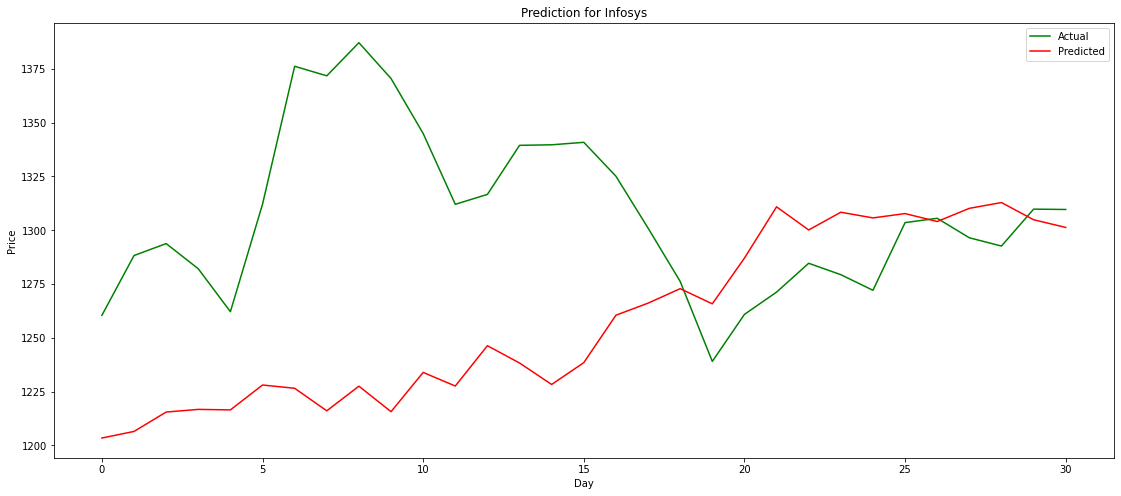

In [ ]:
#original = ds['Close'][2459:].tolist()
plt.figure(figsize=(,8))
plt.plot(compare_df['Actual'],color='green',label='Actual')
plt.plot(compare_df['Predicted'],color='red',label='Predicted')
plt.title('Prediction for Infosys')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()

In [ ]:
#Evaluting
rmse = np.sqrt(np.mean(compare_df['Diff'])**2)
rmse

49.07242313508065

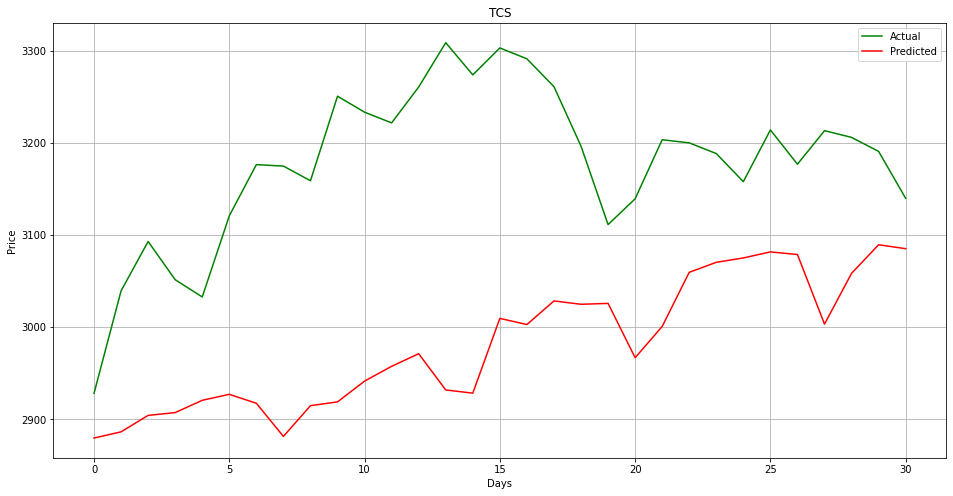

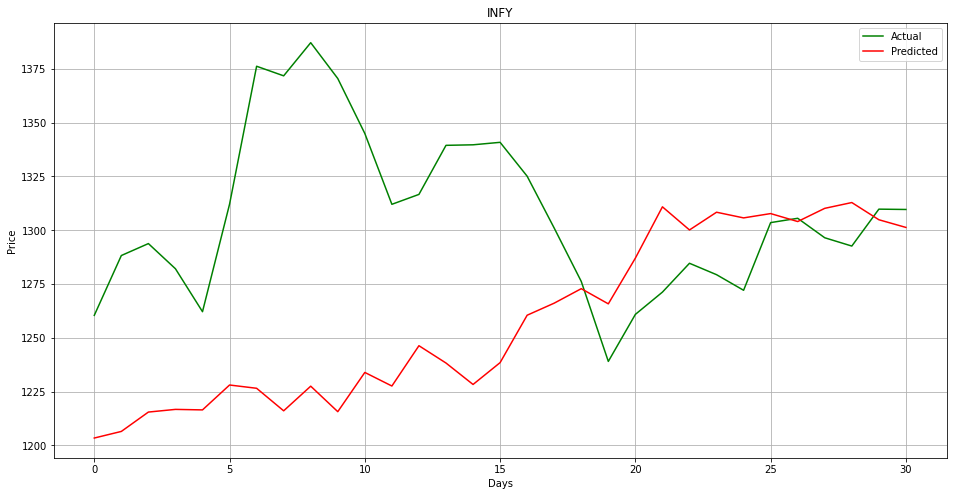

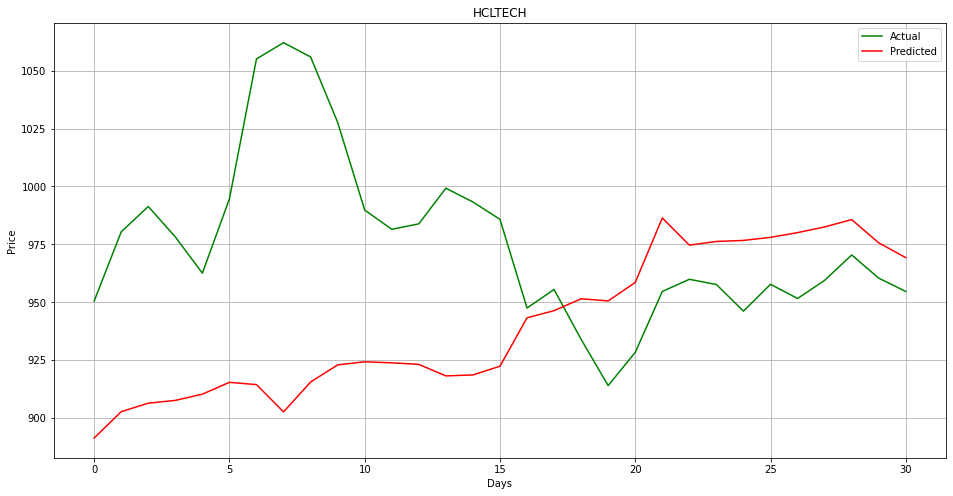

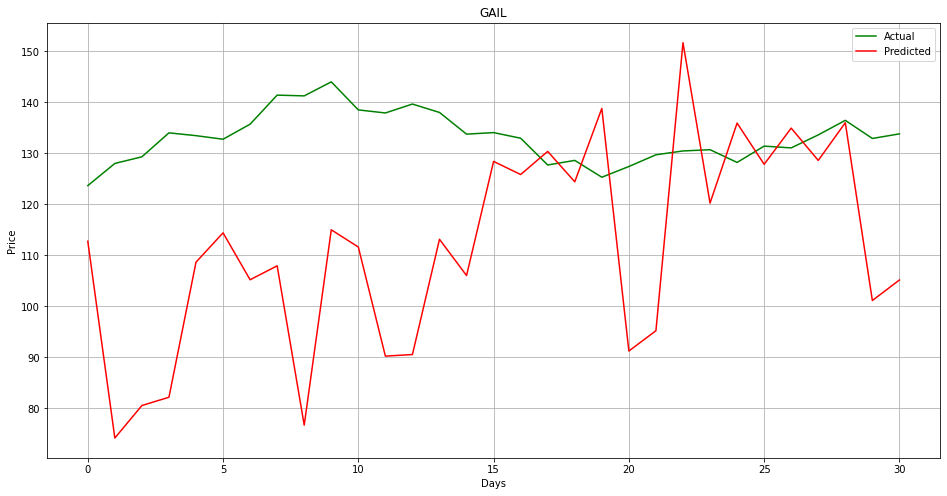

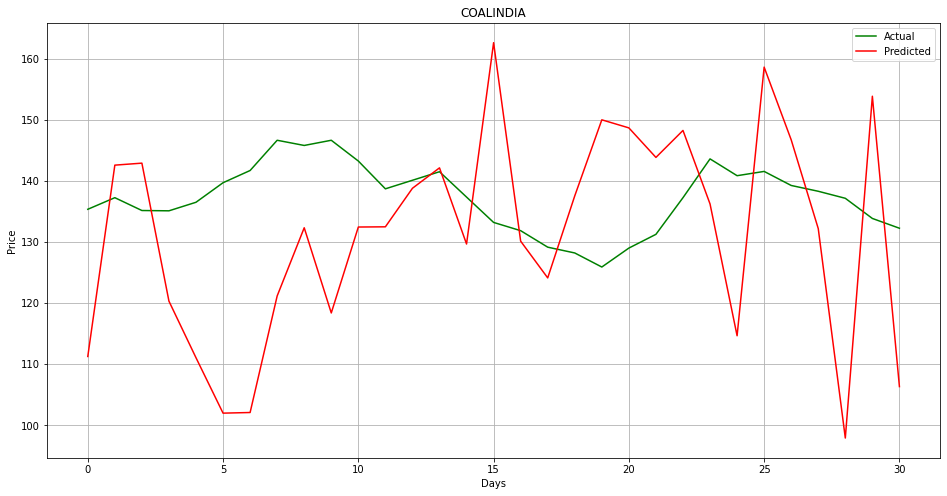

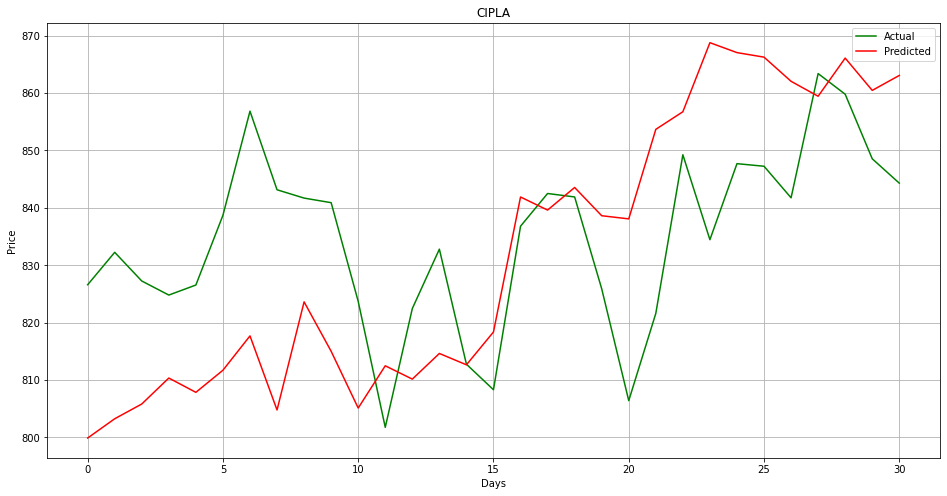

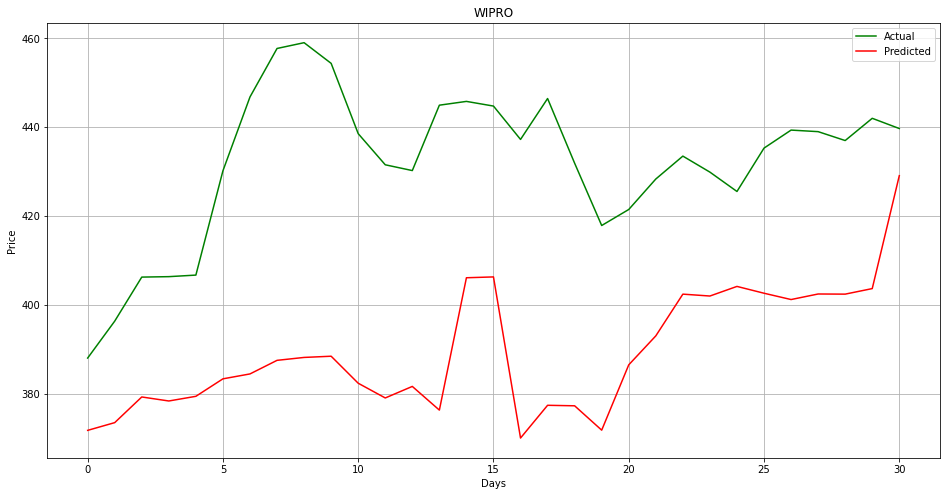

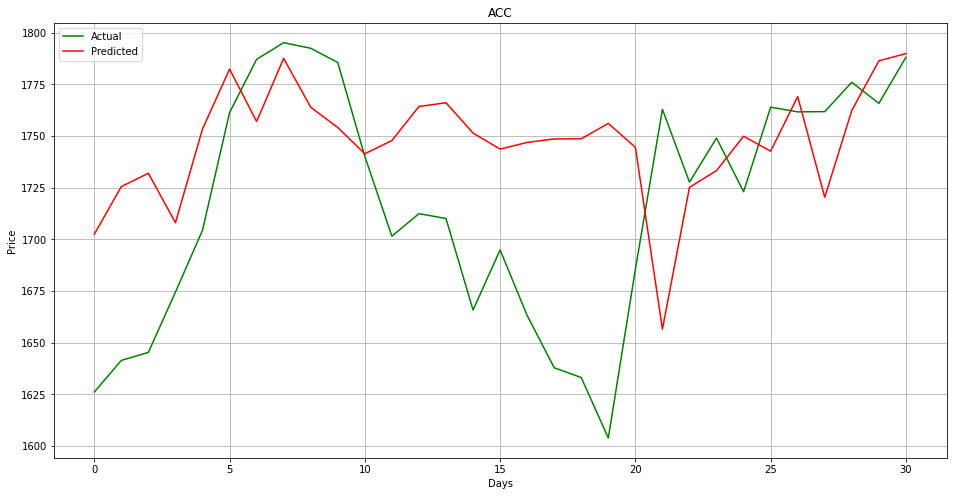

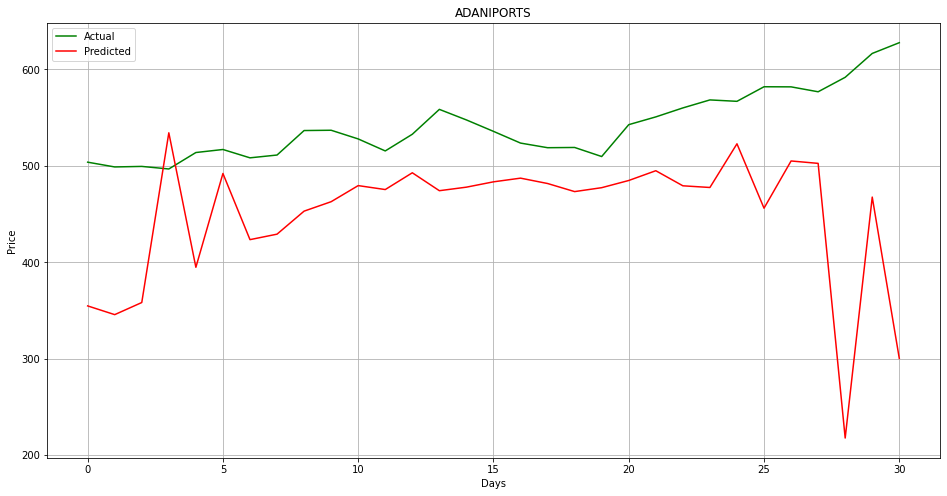

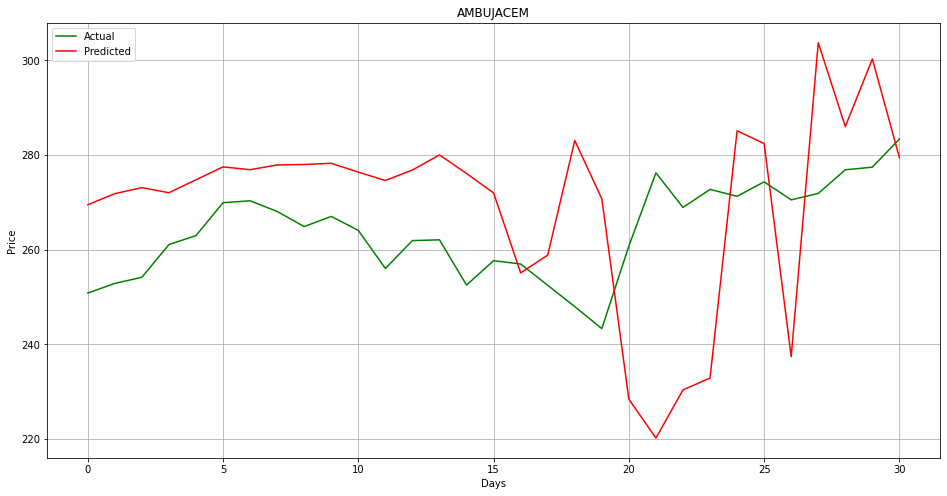

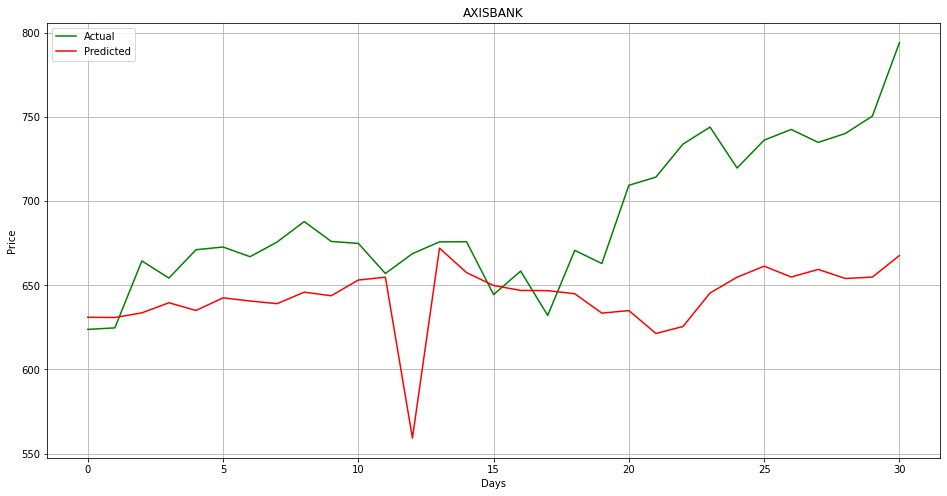

In [ ]:
companies = ['TCS','INFY','HCLTECH','GAIL','COALINDIA','CIPLA','WIPRO','ACC','ADANIPORTS','AMBUJACEM','AXISBANK']
n_steps=30 
for company in companies: 
 
  start = dt.datetime(2011,1,17)
  end = dt.datetime(2020,12,31)
  df = web.DataReader(company+".NS","yahoo",start,end)
  
  start = dt.datetime(2021,1,1)
  end = dt.datetime(2021,2,14)
  actual_df = web.DataReader(company+".NS","yahoo",start,end)


  x_input=[]
  dataset=df

  dataset=dataset['Close'].values
  dataset=dataset[len(dataset)-30:]
  
  n_steps=30
  # demonstrate prediction for next 10 days
  x_input = np.array(dataset.tolist())
  #print(dataset)
  temp_input=list(x_input)
  lst_output=[]
  i=0
  while(i<31):
      
      if(len(temp_input)> past_days):
          x_input=np.array(temp_input[1:])
          #print("{} day input {}".format(i,x_input))
          #print(x_input)
          x_input = x_input.reshape((1, n_steps, n_features))
          #print(x_input)
          yhat = model.predict(x_input, verbose=0)
          #print("{} day output {}".format(i,yhat))
          temp_input.append(yhat[0][0])
          temp_input=temp_input[1:]
          #print(temp_input)
          lst_output.append(yhat[0][0])
          i=i+1
      else:
          x_input = x_input.reshape((1, n_steps, n_features))
          yhat = model.predict(x_input, verbose=0)
          #print(yhat[0])
          temp_input.append(yhat[0][0])
          lst_output.append(yhat[0][0])
          i=i+1
  plt.figure(figsize=(16,8))
  plt.title(company)
  plt.plot(actual_df['Close'].values,color='green',label='Actual')
  plt.plot(lst_output,color='red',label='Predicted')
  plt.xlabel('Days')
  plt.ylabel('Price')
  plt.grid(True)
  plt.legend()
  plt.savefig(company)

In [ ]:
dataset = pd.read_csv('eichermot.csv')

# demonstrate prediction for next 10 days
x_input = np.array(dataset['Close'][:30].tolist())
temp_input=list(x_input)
lst_output=[]
i=0
while(i<22):
    
    if(len(temp_input)> past_days):
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        # print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1

plt.figure(figsize=(16,8))
plt.plot(dataset['Close'][30:52].tolist())
plt.plot(lst_output)

In [ ]:
dataset = pd.read_csv('icicibank.csv')

# demonstrate prediction for next 10 days
x_input = np.array(dataset['Close'][:30].tolist())
temp_input=list(x_input)
lst_output=[]
i=0
while(i<22):
    
    if(len(temp_input)> past_days):
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        # print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1

plt.figure(figsize=(16,8))
plt.plot(dataset['Close'][30:52].tolist())
plt.plot(lst_output)

In [ ]:
 dataset = pd.read_csv('tcs.csv')

# demonstrate prediction for next 10 days
x_input = np.array(dataset['Close'][:30].tolist())
temp_input=list(x_input)
lst_output=[]
i=0
while(i<22):
    
    if(len(temp_input)> past_days):
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        # print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1

plt.figure(figsize=(16,8))
plt.plot(dataset['Close'][30:52].tolist())
plt.plot(lst_output)

In [ ]:
 dataset = pd.read_csv('nestleind.csv')

# demonstrate prediction for next 10 days
x_input = np.array(dataset['Close'][:30].tolist())
temp_input=list(x_input)
lst_output=[]
i=0
while(i<22):
    
    if(len(temp_input)> past_days):
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        # print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1

plt.figure(figsize=(16,8))
plt.plot(dataset['Close'][30:52].tolist())
plt.plot(lst_output)

In [ ]:
 dataset = pd.read_csv('nestleind.csv')

# demonstrate prediction for next 10 days
x_input = np.array(dataset['Close'][:30].tolist())
temp_input=list(x_input)
lst_output=[]
i=0
while(i<22):
    
    if(len(temp_input)> past_days):
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        # print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1

plt.figure(figsize=(16,8))
plt.plot(dataset['Close'][30:52].tolist())
plt.plot(lst_output)